<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/Monthly_International_Airline_Passengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. CNN_RNN_DNN**

In [1]:
!pip install --upgrade tensorflow

In [19]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [20]:
passengers = 'monthly-airline-passengers.csv'
with open(passengers, 'r') as f: # It will same the memory in this way
    print(f"Header looks like this:\n\n{f.readline()}")
    print(f"First line looks like this:\n\n{f.readline()}")
    print(f"Second line looks like this:\n\n{f.readline()}")


Header looks like this:

"Month","Passengers"

First line looks like this:

"1949-01",112

Second line looks like this:

"1949-02",118



In [21]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

## Parsing the raw data

In [22]:
def parse_data_from(filename):
    times = []
    passengers = []

    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for index, row in enumerate(reader):
            times.append(index)
            passengers.append(float(row[1]))

    return times, passengers

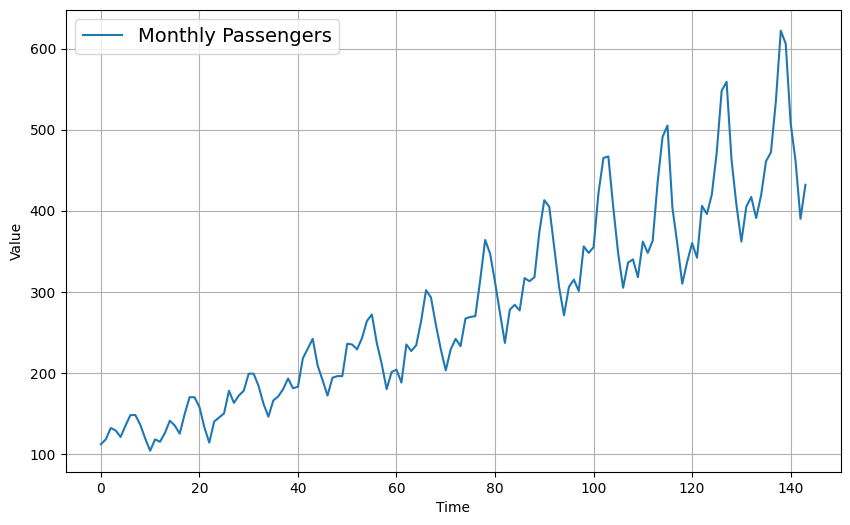

In [23]:
@dataclass
class G:
    passengers_csv = 'monthly-airline-passengers.csv'
    times, passengers = parse_data_from(passengers_csv)
    TIME = np.array(times)
    SERIES = np.array(passengers)
    SPLIT_TIME = 12*11 # Since the seasonality period is 12, we choose 12*10 as the split time here
    WINDOW_SIZE = 12*4 # Since the seasonality period is 12, we choose 12*4 as the window size here
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 200

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, label="Monthly Passengers")
plt.show()

## Processing the data

In [24]:
def train_val_split(time, series, split_time):
    time_train = time[:split_time]
    series_train = series[:split_time]
    time_val = time[split_time:]
    series_val = series[split_time:]
    return time_train, series_train, time_val, series_val

time_train, series_train, time_val, series_val = train_val_split(G.TIME, G.SERIES, G.SPLIT_TIME)



In [25]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

train_set = windowed_dataset(series = series_train,
                             window_size = G.WINDOW_SIZE,
                             batch_size = G.BATCH_SIZE,
                             shuffle_buffer = G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

In [26]:
def create_uncompiled_model():

    # Reset states generated by Keras
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                               strides=1, padding="causal",
                               input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 650.0)
    ])

    return model

In [30]:
def adjust_learning_rate(dataset):

  model = create_uncompiled_model()

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch / 40))

  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

  history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule])

  return history

In [31]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 377.4725 - mae: 377.9725 - learning_rate: 1.0000e-05
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 372.0785 - mae: 372.5785 - learning_rate: 1.0593e-05
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 364.9341 - mae: 365.4341 - learning_rate: 1.1220e-05
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 354.5100 - mae: 355.0100 - learning_rate: 1.1885e-05
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 348.2678 - mae: 348.7678 - learning_rate: 1.2589e-05
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 339.3329 - mae: 339.8329 - learning_rate: 1.3335e-05
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 329.9079 - mae: 330.4079 - learning_rate: 1.4125e-05
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 312.6050 - mae: 313.1050 - learning_rate: 1.4962e-05
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 300.6696 - mae: 301.1696 - learning_rate: 1.5849e-05
E

(1e-05, 0.01, 0.0, 300.0)

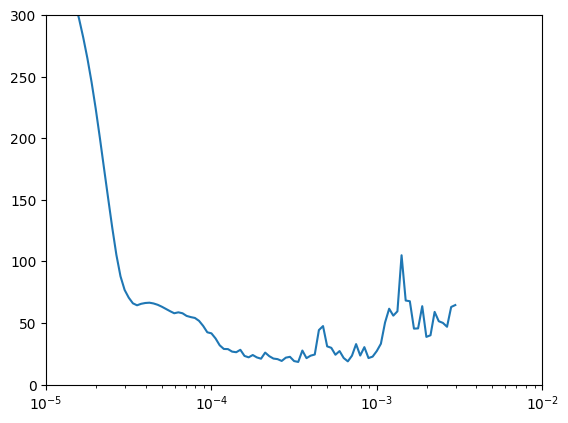

In [35]:
plt.semilogx(lr_history.history['learning_rate'], lr_history.history['loss'])
plt.axis([1e-5, 1e-2 , 0, 300])

## Compiling the model

In [36]:
def create_model():

  model = create_uncompiled_model()

  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                metrics=['mae'])

  return model


In [37]:
model = create_model()

history = model.fit(train_set, epochs=200)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 550.3348 - mae: 550.8348
Epoch 2/200


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 300.9770 - mae: 301.4770
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 132.7536 - mae: 133.2492
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 80.2171 - mae: 80.7171
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 89.0134 - mae: 89.5134
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 72.7036 - mae: 73.2025
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 66.2886 - mae: 66.7867
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 71.6351 - mae: 72.1351
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 68.0674 - mae: 68.5669
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 63.7887 - mae: 64.2883
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 68.7434 - mae: 69.2334
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 63.9649 - mae: 64.4523
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 63.9726 - mae: 64.4687
Epoch 14/200
3/3 ━━━━━━━━━━━━━━━

Evaluatin the forecast

In [38]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(G.BATCH_SIZE).prefetch(1)
    forecast = model.predict(ds)

    return forecast

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


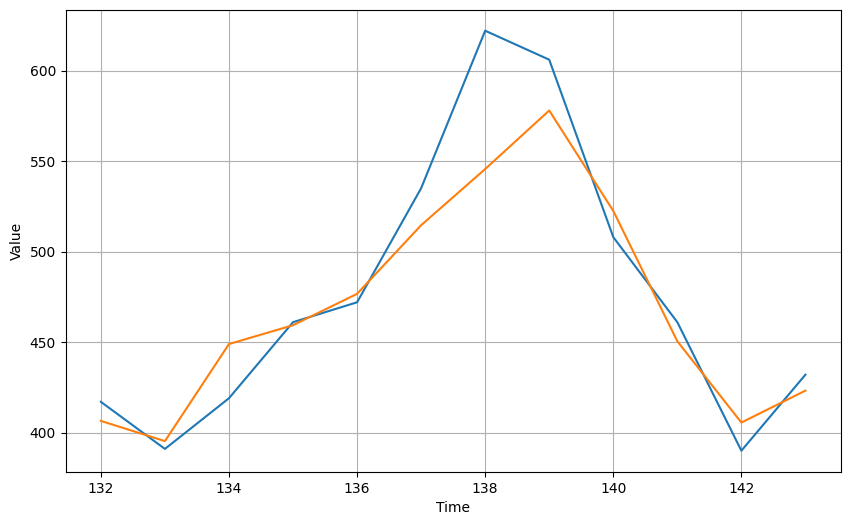

In [39]:
lstm_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze() # Compute the forecast for all sereis

lstm_forecast = lstm_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1] # slice the forecast to get only the prediction for the validation set


# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_val, series_val)
plot_series(time_val, lstm_forecast)

In [40]:
# Define the function to compute MSE and MAE
def compute_metrics(true_series, forecast):
    # Calculate mean squared error
    mse = np.mean((true_series - forecast) ** 2)
    # Calculate mean absolute error
    mae = np.mean(np.abs(true_series - forecast))
    return mse, mae


mse, mae = compute_metrics(series_val, lstm_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 727.71, mae: 18.78 for forecast


MAE=18.78, this value is greater than the results below as you will see soon. In this case, you will see that PyCaret performance better than CNN_RNN_DNN Method.

# **2.PyCaret**

## Preparation

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. With PyCaret, you spend less time coding and more time on analysis. You can train your model, analyze it, iterate faster than ever before, and deploy it instantaneously as a REST API or even build a simple front-end ML app, all from your favorite Notebook.

In [1]:
pip install pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 45.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of selenium to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of selenium t

In [8]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.datasets import get_data
#from pycaret.time_series import TSForecastingExperiment
from pycaret.time_series import *

#from dataclasses import dataclass

In [3]:
data = get_data('monthly-airline-passengers', verbose=False)

data['Month'] = pd.to_datetime(data['Month'])

data.set_index('Month', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [12]:
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


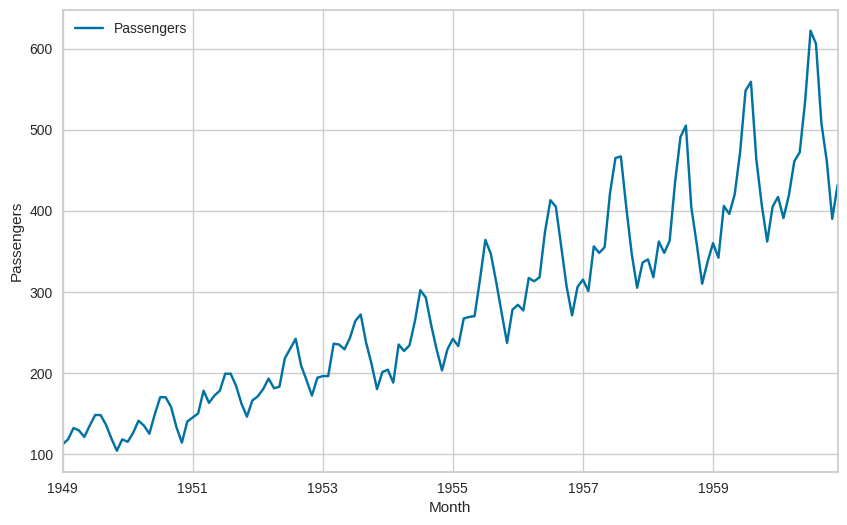

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(ax=ax)
ax.set_ylabel('Passengers')
plt.show()

In [14]:
fh=12

# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
fig_kwargs = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

## EDA (not necessary)

In [7]:
eda = TSForecastingExperiment()
eda.setup(data, target='Passengers', fh = fh, fold=3, session_id=31, fig_kwargs=fig_kwargs)

,Description,Value
0,session_id,31
1,Target,Passengers
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(144, 1)"
5,Transformed data shape,"(144, 1)"
6,Transformed train set shape,"(132, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


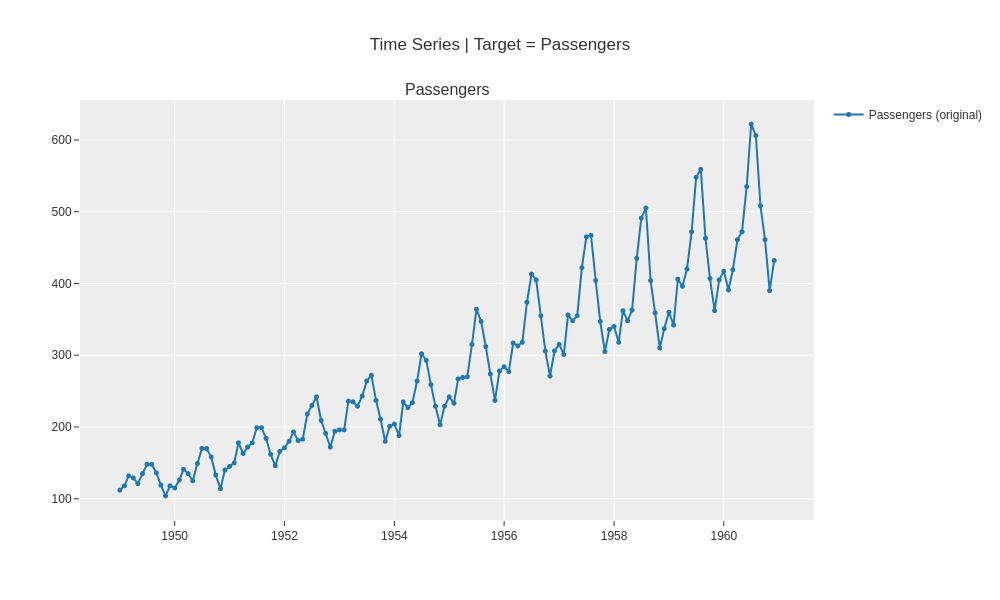

In [8]:
# NOTE: This is the same as `eda.plot_model(plot="ts")`
eda.plot_model()

 For now, our data does not have any missing values or any transformations. So **Data Input (by user), i.e. Original data = Imputed data = Transformed data = Data fed to models**. We can verify this by plotting the internal datasets by specifying the `plot_data_type` `data_kwargs`.

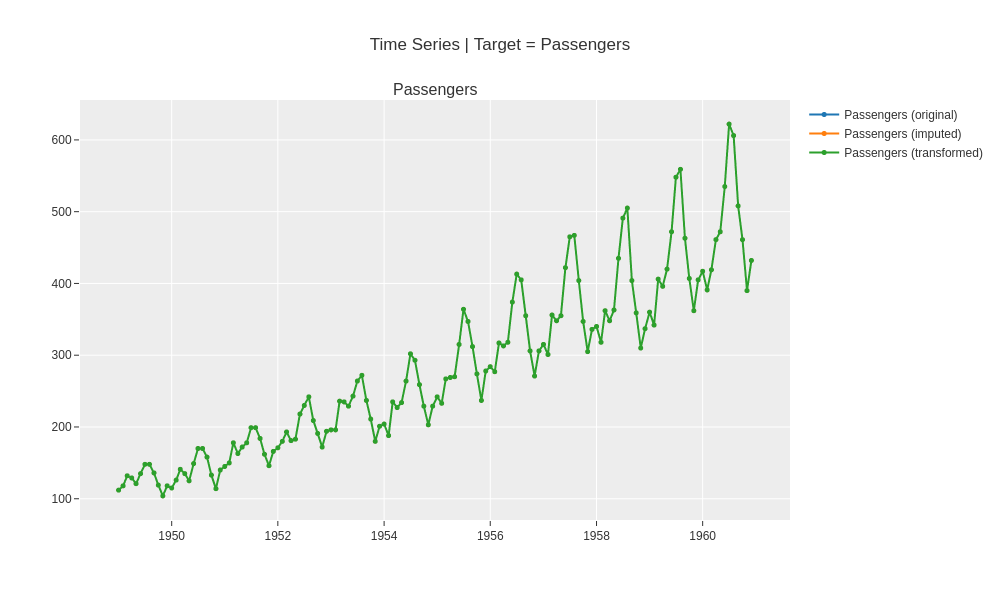

In [9]:
eda.plot_model(data_kwargs={"plot_data_type": ["original", "imputed", "transformed"]})

In the plots above, we notice

Peaking at f ~= 0 indicating that we need to difference the data.
Peaking at f = 0.0833, 0.1677, 0.25, 0.3333, 0.4167. All these are multiple of 0.0833. Hence 0.0833 is the fundamental frequency and the seasonal period is 1/0.0833 = 12.

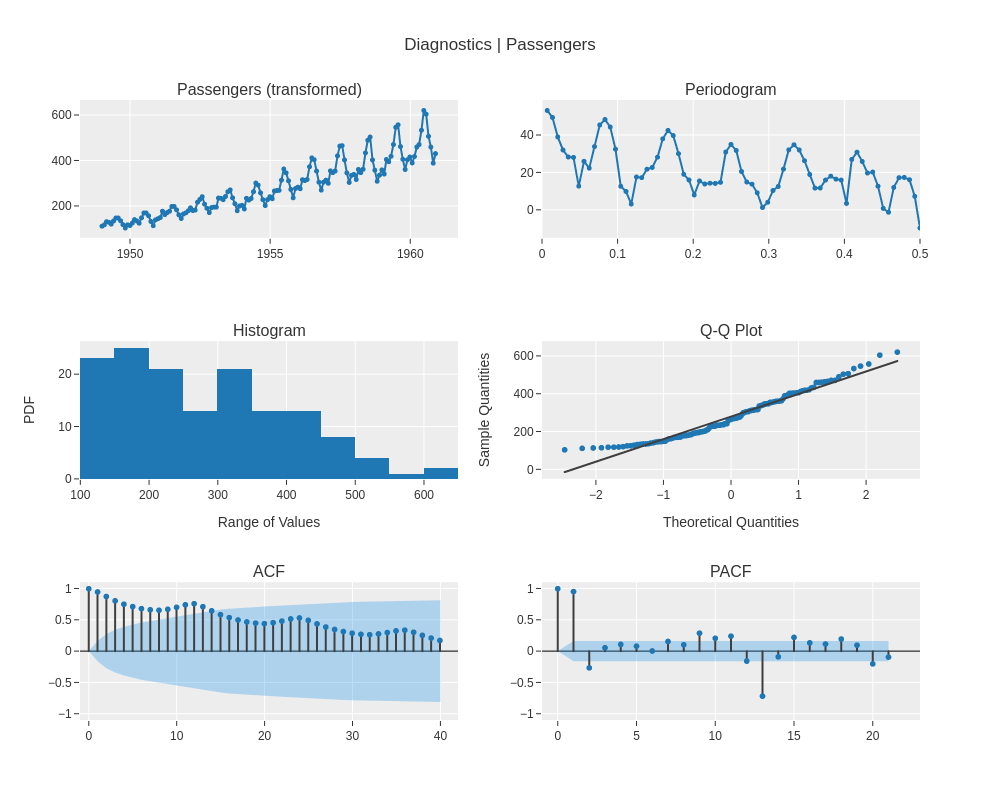

In [10]:
# Alternately, the diagnostics plot provides all these details in a convenient call.

eda.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

Our diagnostic plots indicated the need to difference and the presence of a seasonal period of 12. Let's see what happends when we remove this from the model. What other characteristics are left in the model that would need to be taken care of?

This can be achieved through the difference plots. Along with the difference plots, we will plot the corresponding ACF, PACF and Periodogram for further diagnostics.

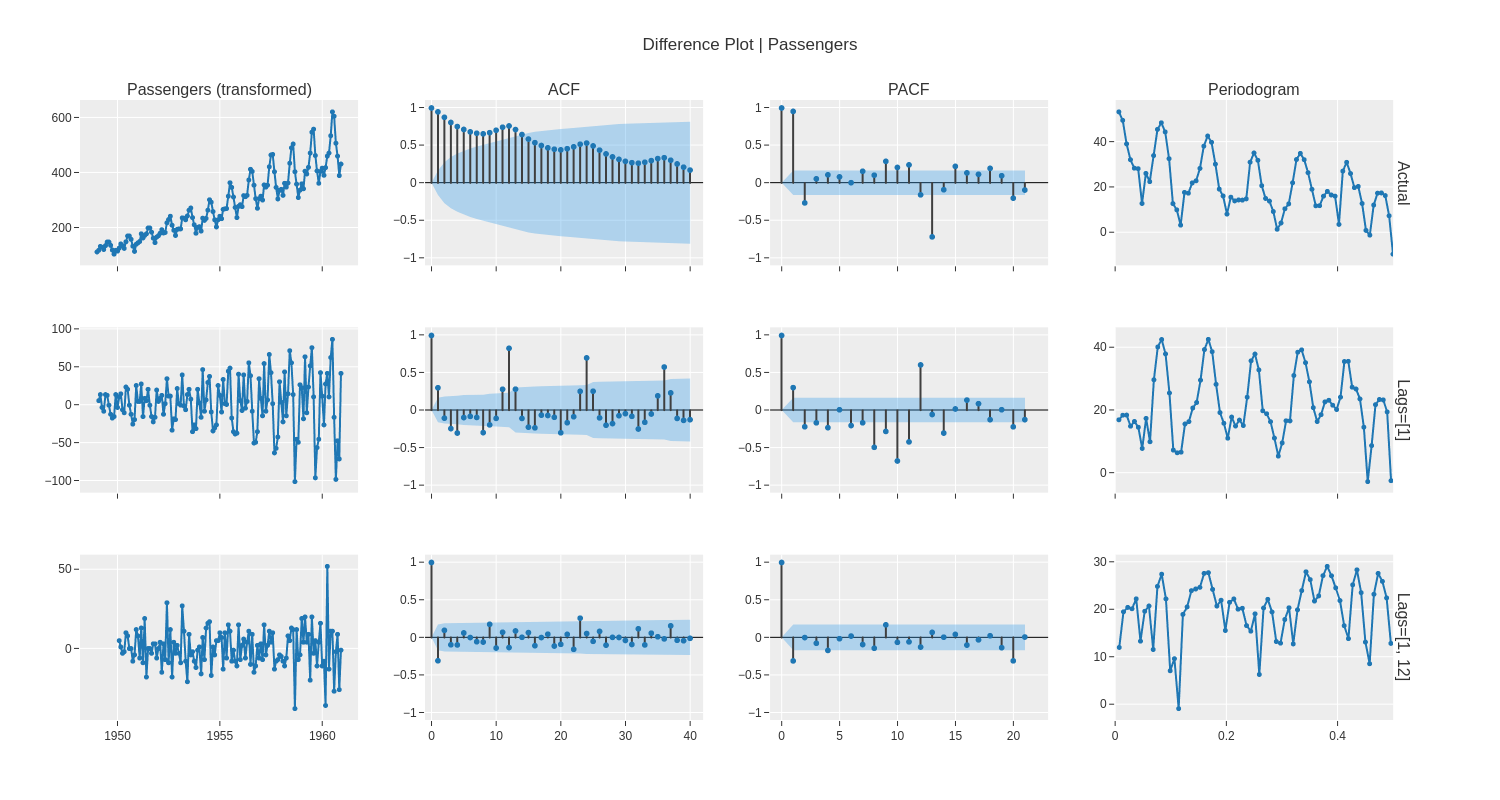

In [11]:

#   - Corresponds to applying a standard first difference to handle trend, and
#     followed by a seasonal difference (at lag 12) to attempt to account for
#     seasonal dependence.
# Ref: https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html
eda.plot_model(
    plot="diff",
    data_kwargs={"lags_list": [[1], [1, 12]], "acf": True, "pacf": True, "periodogram": True},
    fig_kwargs={"height": 800, "width": 1500}
)
# The output is shown below
# Row 1: Original
# Row 2: d = 1
# Row 3: First (d = 1) then (D = 1, s = 12)




# ## NOTE: Another way to specify differences is using order_list
# # Row 1: Original
# # Row 2: d = 1
# # Row 3: d = 2
# eda.plot_model(
#     plot="diff",
#     data_kwargs={
#         "order_list": [1, 2],
#         "acf": True, "pacf": True, "periodogram": True
#     },
#     fig_kwargs={"height": 600, "width": 1200}
# )

Observations:


In the second row, we have only removed the wandering behavior by taking a first difference. This can be seen in the ACF plot (extended autocorrelations are gone) and Periodogram (peaking at f =~ 0 is squished). The ACF (preaking at seasonal period of 12 and its multiples) and PACF (peaking at fundamental frequency of 0.0833 and its multiples) still show the seasonal behavior.
In the third row, we have taken first difference followed by a seasonal difference of 12. Now, we can see that the peaking at seasonal multiples is gone from both ACF and Periodogram. There is still a little bit of autoregresssive properties that we have not taken care of but by looking at the PACF, maybe p=1 seems like a reasonable value to use (most lags after that are insignificant).
Conclusion

If you were modeling this with ARIMA, the model to try would be ARIMA(1,1,0)x(0,1,0,12).
Other models could use this information appropriately. For example, reduced regression models could remove the trend and seasonality of 12 (i.e. make the data stationary) before modeling the rest of the autoregressive properties. Luckily, the pycaret time series module will take care of this **internally**.

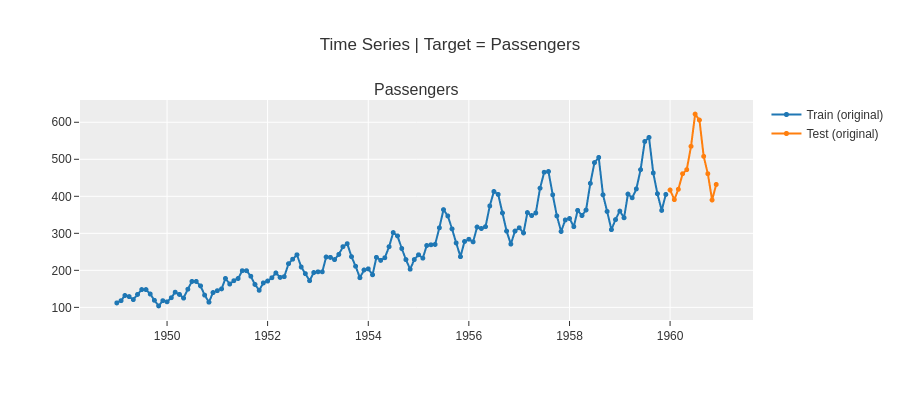

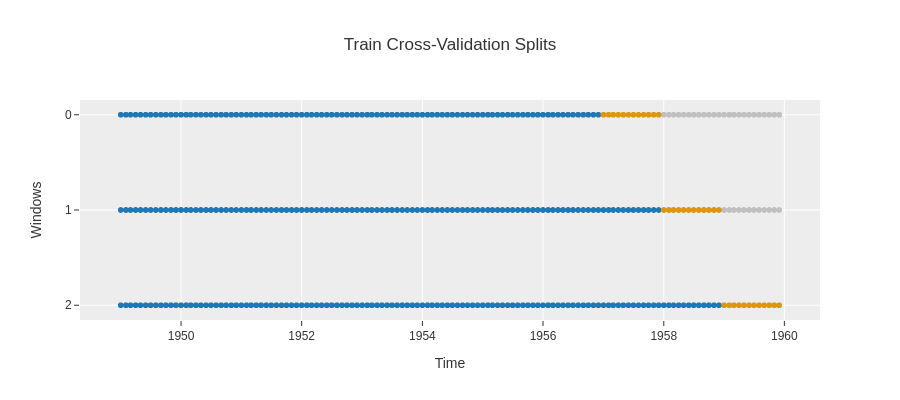

In [12]:
# Show the train-test splits on the dataset
# Internally split - len(fh) as test set, remaining used as test set
eda.plot_model(plot="train_test_split", fig_kwargs={"height": 400, "width": 900})

# Show the Cross Validation splits inside the train set
# The blue dots represent the training data for each fold.
# The orange dots represent the validation data for each fold
eda.plot_model(plot="cv", fig_kwargs={"height": 400, "width": 900})

## Set Up

In [15]:
s = setup(data, target='Passengers', fh = fh, fold=3, session_id=31, fig_kwargs=fig_kwargs)

,Description,Value
0,session_id,31
1,Target,Passengers
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(144, 1)"
5,Transformed data shape,"(144, 1)"
6,Transformed train set shape,"(132, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [16]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,144.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,280.298611
3,Summary,Statistics,Transformed,Median,,265.5
4,Summary,Statistics,Transformed,Standard Deviation,,119.966317
5,Summary,Statistics,Transformed,Variance,,14391.917201
6,Summary,Statistics,Transformed,Kurtosis,,-0.364942
7,Summary,Statistics,Transformed,Skewness,,0.58316
8,Summary,Statistics,Transformed,# Distinct Values,,118.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",1606.083817


## Compare Models

In [48]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,0.5852,0.6105,17.1926,20.1633,0.0435,0.0439,0.8918,0.1667
ets,ETS,0.5931,0.6212,17.4165,20.5102,0.0440,0.0445,0.8882,0.2400
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.6482,0.7089,19.1419,23.4703,0.0477,0.0475,0.8528,0.9767
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6813,0.7866,20.0334,25.9670,0.0491,0.0499,0.8113,0.5767
arima,ARIMA,0.6830,0.6735,20.0069,22.2199,0.0501,0.0507,0.8677,0.1833
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7004,0.7702,20.6084,25.4401,0.0509,0.0514,0.8215,0.9000
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7004,0.7703,20.6086,25.4405,0.0509,0.0514,0.8215,1.0100
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.7029,0.7732,20.6816,25.5362,0.0511,0.0516,0.8201,1.1000
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.7048,0.7751,20.7373,25.6005,0.0512,0.0517,0.8193,0.5467
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7048,0.7751,20.7366,25.6009,0.0512,0.0517,0.8192,0.5600


Processing:   0%|          | 0/121 [00:00<?, ?it/s]

## Prediction

In [49]:
# The predict_model function returns y_pred.
pred = predict_model(best)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,0.3382,0.4575,10.2997,15.8074,0.0221,0.0216,0.9549


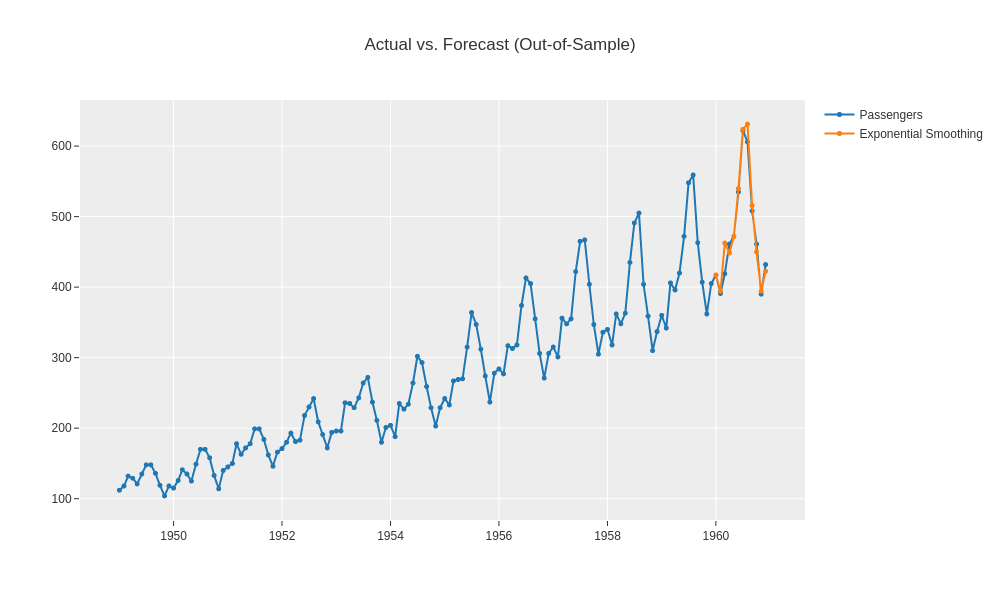

In [50]:
plot_model(best, plot = 'forecast')

In [51]:
# If one wants to predict the future 36 months

pred_future = predict_model(best, fh=36)

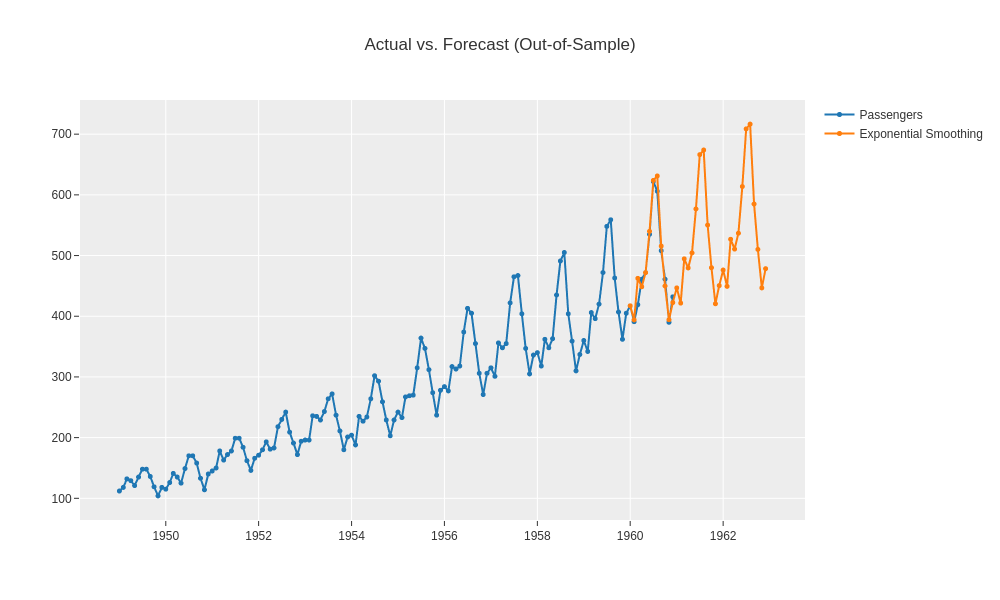

In [52]:
plot_model(best, plot = 'forecast', data_kwargs = {'fh': 36})

## Save and deploy models

In [53]:
# Finalize model
final_best = finalize_model(best)

# Save model
save_model(final_best, 'my_final_best_model')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ExponentialSmoothing(seasonal='mul',
                                                                                                                                                      sp=12,
                                                                                                                                                      trend='add'))]))]))]))]),
 'my_final_best_model.pkl')

In [54]:
# To load model back

loaded_model = load_model('my_final_best_model')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('model',
                                                                ForecastingPipeline(steps=[('forecaster',
                                                                                            TransformedTargetForecaster(steps=[('model',
                                                                                                                                ExponentialSmoothing(seasonal='mul',
                                                                                                                                                     sp=12,
                                                                                                                                                     trend='add'))]))]))]))])


In [56]:
pred_future_pro = predict_model(loaded_model, fh=36)

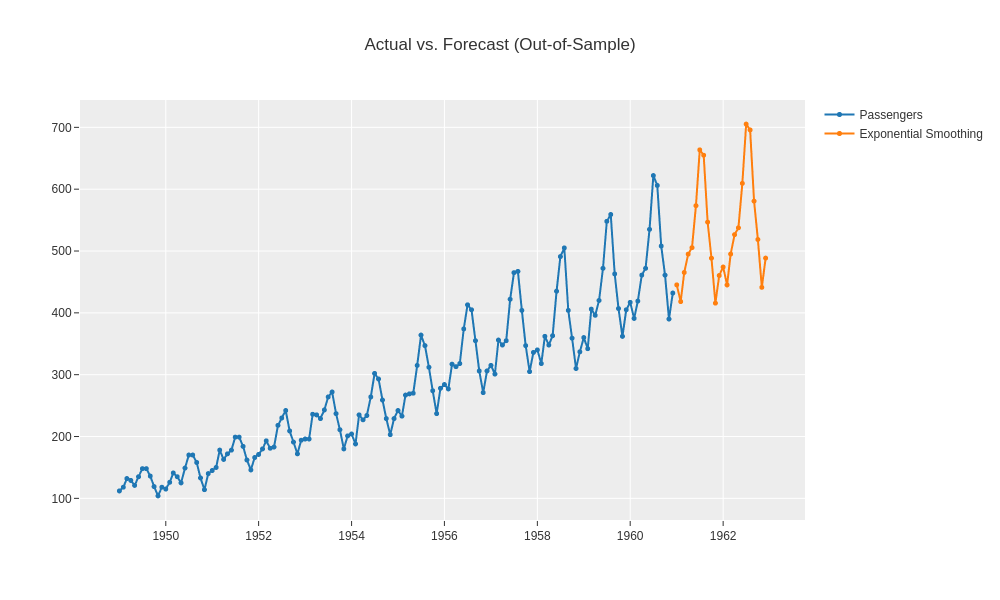

In [59]:
plot_model(loaded_model, plot = 'forecast', data_kwargs = {'fh': 24})

# **3.SARIMA**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [23]:
df = pd.read_csv('monthly-airline-passengers.csv', index_col='Month', parse_dates=True)

In [24]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


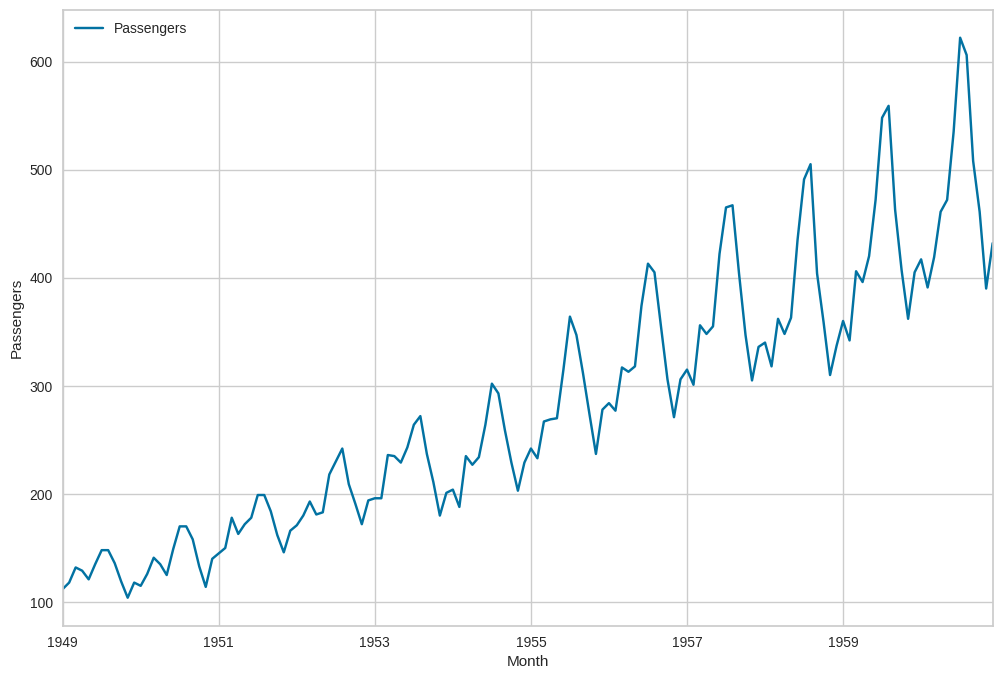

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 8))
df.plot(ax=ax1)
ax1.set_ylabel('Passengers')
plt.show()

Since the seasonality is multiplicative, we need to take a log transformation before using SARIMA model.

In [26]:
df['log_passengers'] = np.log(df['Passengers'])

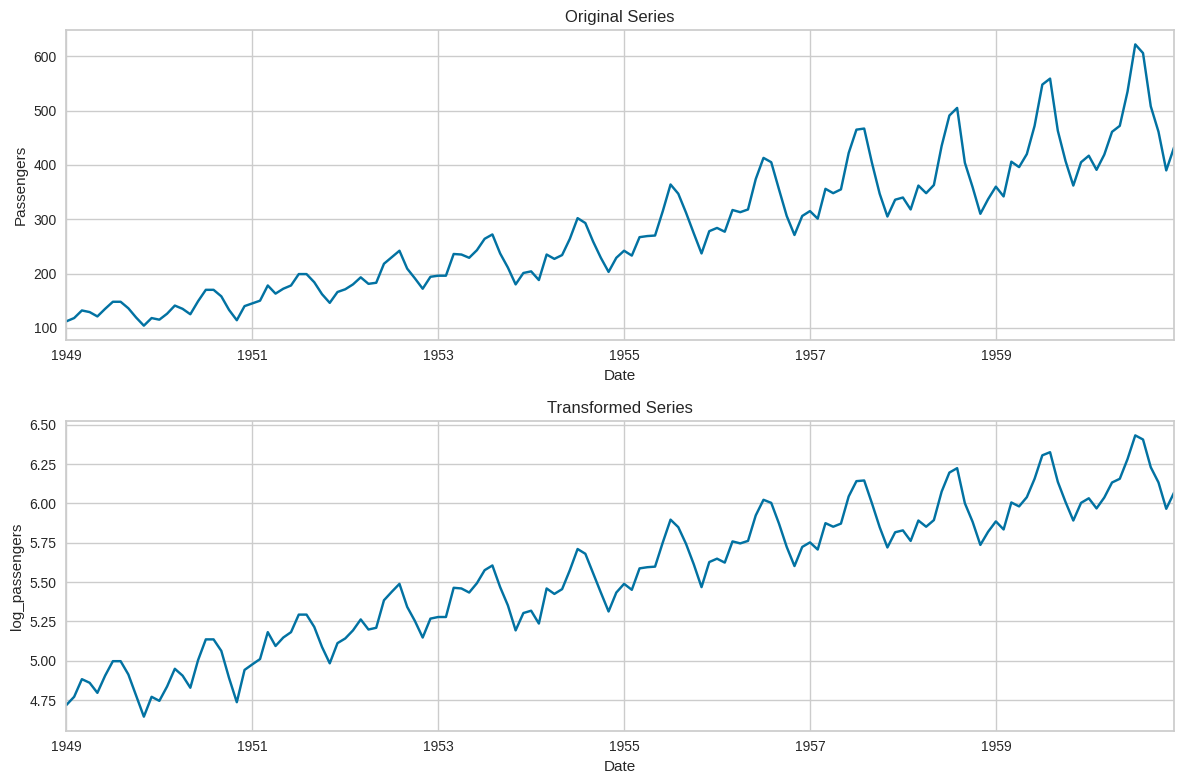

In [27]:
fig, axs = plt.subplots(2,1, figsize=(12, 8))
df['Passengers'].plot(ax=axs[0])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Passengers')
axs[0].set_title('Original Series')


df['log_passengers'].plot(ax=axs[1])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('log_passengers')
axs[1].set_title('Transformed Series')

plt.tight_layout()
plt.show()

In [28]:
# define the log transformed dataframe
df_log = df['log_passengers'].copy()

## Choosing Order

### Manualy 1st non-seasonal differencing and 1st seasonal differencing

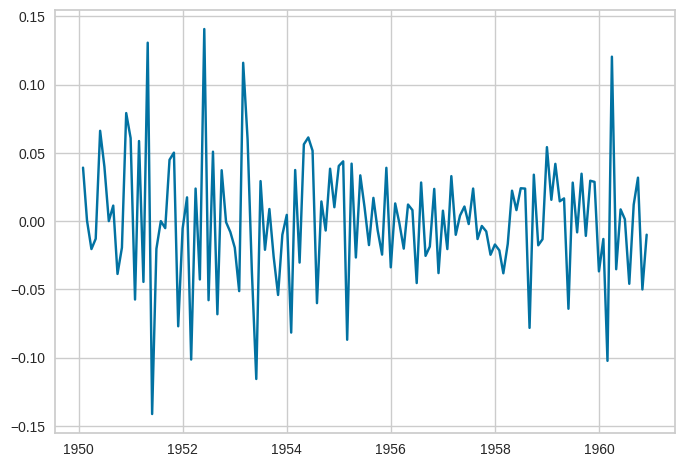

In [29]:
df_log_diff = df_log.diff(1).diff(12).dropna()

plt.plot(df_log_diff)
plt.show()

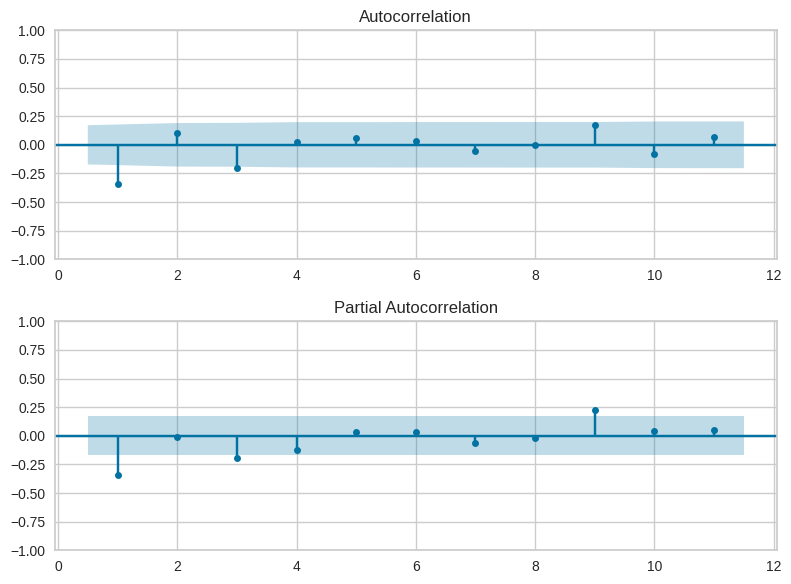

In [30]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6))

plot_acf(df_log_diff, ax=ax1, zero=False, lags=11)
plot_pacf(df_log_diff, ax=ax2, zero=False, lags=11)

plt.tight_layout()
plt.show()


ACF tails off after lag=1, PACF tails off after lag = 1, but both figs have no strong signs. One may try (1,0),(0,1)

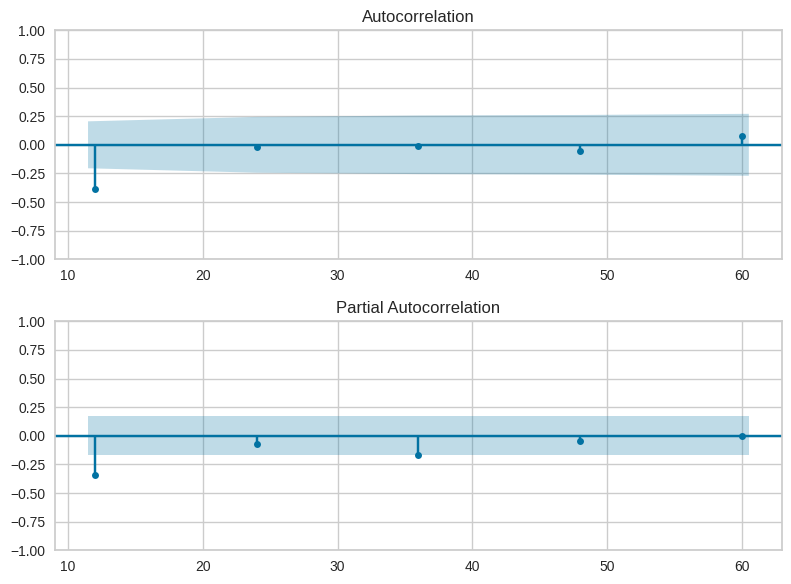

In [31]:
lags = [12, 24, 36, 48, 60]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6))

plot_acf(df_log_diff, ax=ax1, zero=False, lags=lags)
plot_pacf(df_log_diff, ax=ax2, zero=False, lags=lags)

plt.tight_layout()
plt.show()

ACF and PACF cut off after lags Q=1, P =0

In [32]:
# Order (1,1,0) (0,1,1)_12

model = SARIMAX(df_log, order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     log_passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 240.406
Date:                            Thu, 15 Aug 2024   AIC                           -474.813
Time:                                    16:28:27   BIC                           -466.187
Sample:                                01-01-1949   HQIC                          -471.308
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3744      0.071     -5.270      0.000      -0.514      -0.235
ar.S.L12      -0.4638      0.071   

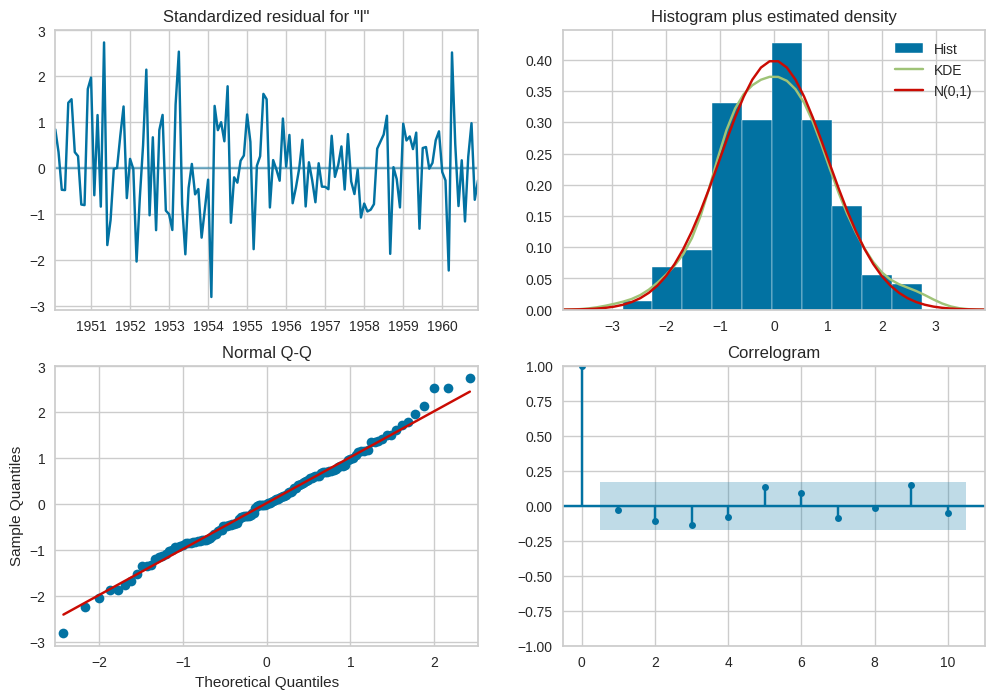

In [33]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

In [34]:
# Order (0,1,1) (0,1,1)_12

model = SARIMAX(df_log, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     log_passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 244.953
Date:                            Thu, 15 Aug 2024   AIC                           -481.906
Time:                                    16:28:35   BIC                           -470.405
Sample:                                01-01-1949   HQIC                          -477.233
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4143      0.074     -5.633      0.000      -0.558      -0.270
ar.S.L12      -0.1105      0.185   

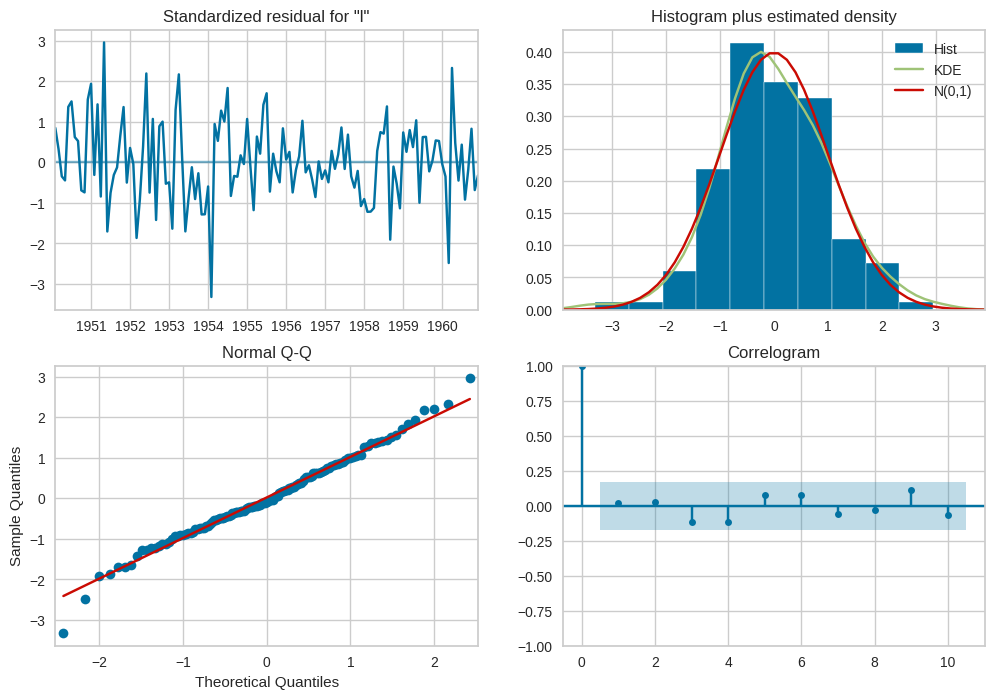

In [35]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

These two model performance similar, in terms of AIC, the second model with the order (0,1,1) (0,1,1)_12 is slightly better

### Automated model selection

In [36]:
pip install pmdarima

In [37]:
import pmdarima as pm

model = pm.auto_arima(df_log, seasonal=True, m=12,
                      d=1, D=1,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-477.718, Time=6.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-434.830, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-474.813, Time=1.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-483.393, Time=2.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-449.978, Time=0.43 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-481.906, Time=3.01 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-481.956, Time=6.28 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-477.399, Time=1.91 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-479.901, Time=4.35 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-467.553, Time=0.80 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-481.893, Time=3.54 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-481.610, Time=4.26 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-481.484, Time=4.28 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-479.399, Time=4.55 sec
 ARIMA(0,1,1)(0,1,1

Great! The best model is same to our manual selection.

## Forecast

In [38]:
model = SARIMAX(df_log, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

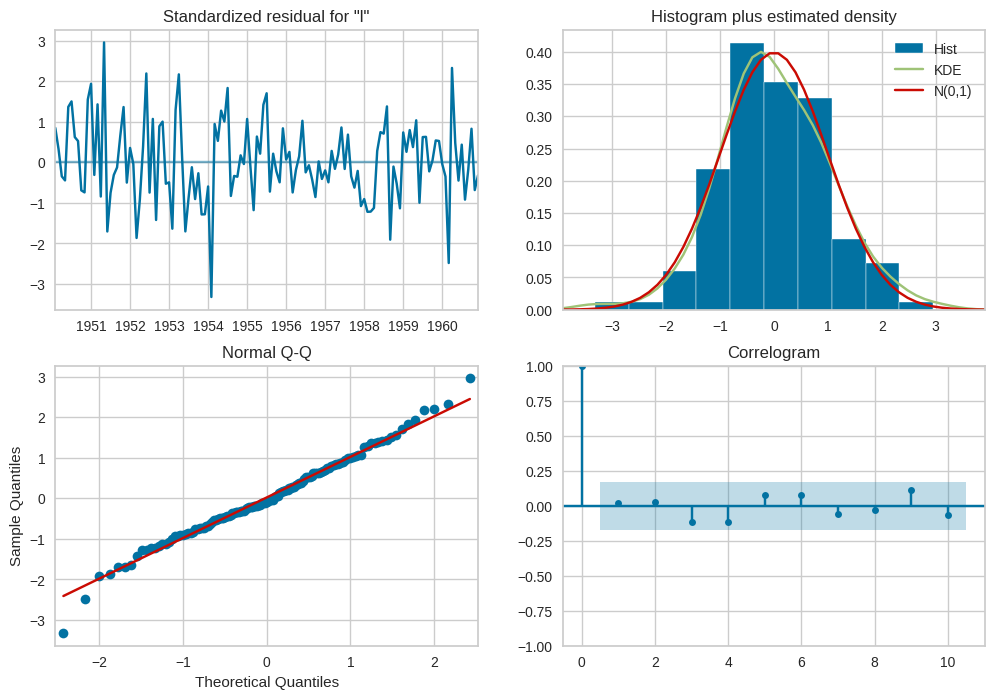

In [39]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

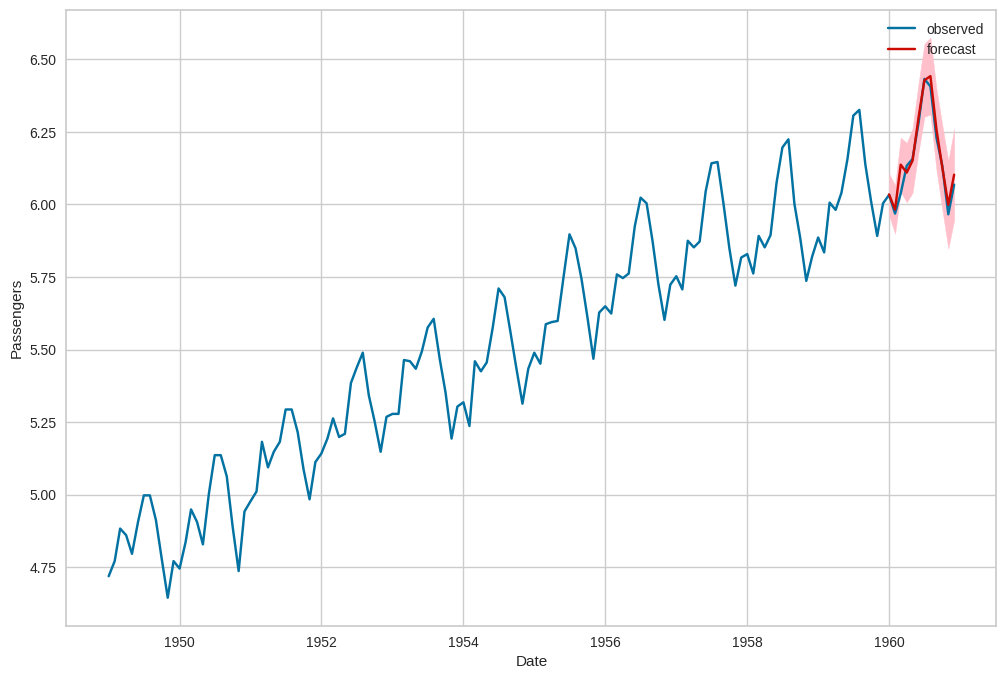

In [40]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-12, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.iloc[:,0]
upper_limits = confidence_intervals.iloc[:,1]

fig, ax = plt.subplots(figsize=(12, 8))
# plot the data
plt.plot(df_log.index, df_log, label='observed')

# plot your mean forecast
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits,
         upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

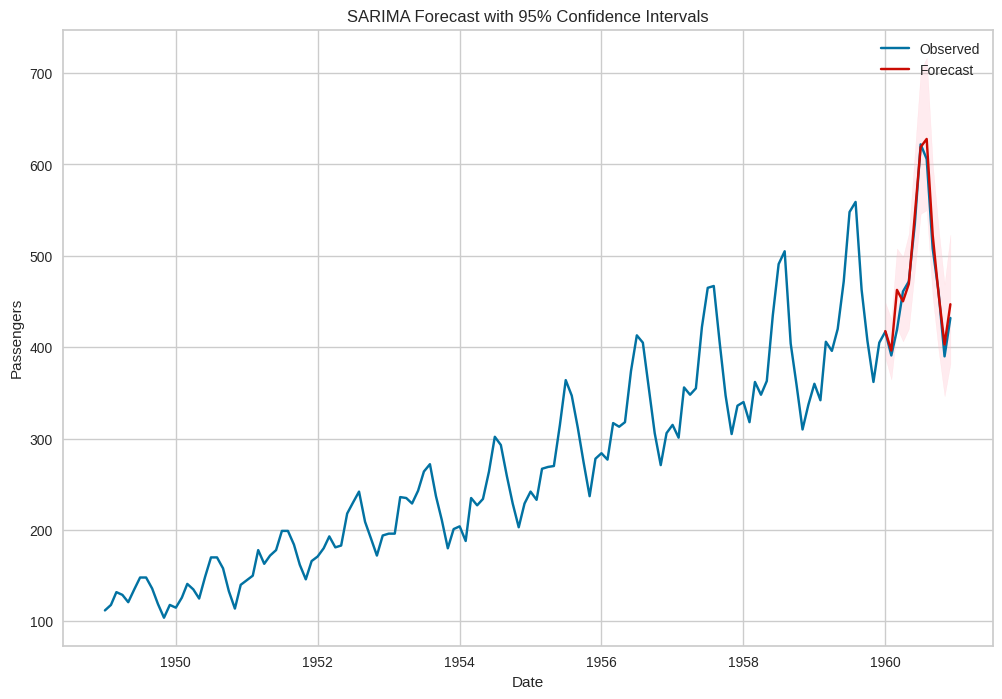

In [41]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-12, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean



# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.iloc[:,0]
upper_limits = confidence_intervals.iloc[:,1]


# Convert the values back to the original scale

mean_forecast_original_scale = np.exp(mean_forecast)

lower_limits_original_scale = np.exp(lower_limits)
upper_limits_original_scale = np.exp(upper_limits)


fig, ax = plt.subplots(figsize=(12, 8))
# Plot the original series
plt.plot(df['Passengers'], label='Observed')

# Plot the forecasted mean
plt.plot(mean_forecast_original_scale, color='r', label='Forecast')

# Plot the confidence intervals
plt.fill_between(mean_forecast_original_scale.index,
                 lower_limits_original_scale,
                 upper_limits_original_scale, color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('SARIMA Forecast with 95% Confidence Intervals')
plt.legend()
plt.show()

## Evaluation

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_values = df['Passengers'][-12:]

# Compute MAE
mae = mean_absolute_error(actual_values, mean_forecast_original_scale)

# Compute MSE
mse = mean_squared_error(actual_values, mean_forecast_original_scale)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

Mean Absolute Error (MAE): 11.884127218761103
Mean Squared Error (MSE): 271.73363365739266


This moder performances better than LSTM and worse than PyCaret. So, we will apply the model obtained from PyCaret: Exponential Moving model

## Save and update models

In [43]:
import joblib

filename = 'sarima_model.sav'
joblib.dump(model, filename)


['sarima_model.sav']

In [44]:
# When you want to load the model:

# filename = 'sarima_model.sav
# loaded_model = joblib.load(filename)


In [45]:
# When you want to undate the model with the new data

#loaded_model.update(new_data)